In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline
from sqlalchemy import create_engine
from sqlalchemy import inspect
import openpyxl

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

# use python get_mta.py "(2104|2105|2106|2107|2108|2109)" in Terminal

engine = create_engine("sqlite:///mta_data.db")

df = pd.read_sql('SELECT * FROM mta_data WHERE DESC = "REGULAR";', engine)


In [2]:
#create a "key" so don't have to keep typing all the column names
df['key']=df['SCP']+df['UNIT']+df['C/A']+df['STATION']+df['LINENAME']

#create a datetime object out of date and time so they aren't strings
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, 
                                format="%m/%d/%Y %H:%M:%S")
#sort everything by turnstile and by date so can subtract the right things
df.sort_values(['key','DATE_TIME'],ascending=True,inplace = True, ignore_index = True)

#from https://github.com/rjh336/mta_metis/blob/master/benson_cleaner.ipynb
#create a column with just the hours so can find the hours we're intersted in. 
df["just_time"]  = df['DATE_TIME'].apply(lambda x: x.time())
#create a day of the week so can delete Saturdays and Sundays
df['DOW'] = df[['DATE_TIME']]\
    .apply(lambda x: datetime.datetime.strftime(x['DATE_TIME'], '%A'), axis=1)


#create the differences in the entries from the last reading. restarts each day
#from https://stackoverflow.com/questions/20648346/computing-diffs-within-groups-of-a-dataframe
df['entries_diffs'] = df.groupby(['key','DATE'])['ENTRIES'].transform(lambda x: x.diff()) 
#create the differences in the exits from the last reading. restarts each day
df['exits_diffs'] = df.groupby(['key','DATE'])['EXITS'].transform(lambda x: x.diff()) 

In [3]:
#create a new dataframes so the old one still exists
# drop apparently unnecessary columns or rows in each change. 
# Note: columns/rows are still in old data frames
# need to keep DATE because using to find duplicates much later
# need to keep LINENAME because multiple STATIONS with same name
df2 = df.drop(['DIVISION','TIME','DESC'],axis = 1).copy()
mask = ((df2.DOW != 'Saturday') & (df2.DOW != 'Sunday'))
df3 = df2[mask].copy()
df3 = df3.drop(['ENTRIES','EXITS'],axis = 1).copy()
df3.describe()

,entries_diffs,exits_diffs
count,2.976734e+06,2.976734e+06
mean,7.154853e+02,3.855130e+02
std,2.380641e+06,2.412829e+06
min,-1.604324e+09,-1.804896e+09
25%,3.000000e+00,5.000000e+00
50%,3.400000e+01,3.400000e+01
75%,1.040000e+02,1.020000e+02
max,2.139010e+09,2.005378e+09


In [4]:
# describe shows large outliers
# this code drops outliers - anything bigger than number of seconds in a day
# from https://github.com/rjh336/mta_metis/blob/master/benson_cleaner.ipynb
threshold = 86400 #number of seconds in the day

## DROP OUTLIERS
df3 = df3[(df3['entries_diffs'] < threshold) & (df3['exits_diffs'] < threshold)]
df3 = df3[(df3['entries_diffs'] > -threshold) & (df3['exits_diffs'] > -threshold)]
df4 = df3.copy()

In [5]:
def convert_neg_counts(row,keycol):
    '''
    from MTA pair 2. converts negative numbers to positive ones
    Exploration showed some of the cumulative counts were backwards, so getting 
    the difference created negative numbers; 
    they should just be converted to positive
    '''

    counter = row[keycol]
    if counter < 0:
        counter = -counter  
    return counter


df4['exits_diffs'] = df4.apply(convert_neg_counts, axis=1,keycol= 'exits_diffs')
df4['entries_diffs'] = df4.apply(convert_neg_counts, axis=1,keycol= 'entries_diffs')

In [6]:
#am rush hour dataframe: 8 am to 9:30. 8 am is when most of the data is collected
mask = ((df4.just_time >= datetime.time(8)) & (df4.just_time <= datetime.time(9, 30)))
df_am = df4[mask].copy()

# mask for evening rush hours: 5 pm to 8 pm. 8 pm because that's when most of 
# the data is collected
mask = ((df4.just_time >= datetime.time(17)) & (df4.just_time <= datetime.time(20)))
df_pm = df4[mask].copy()


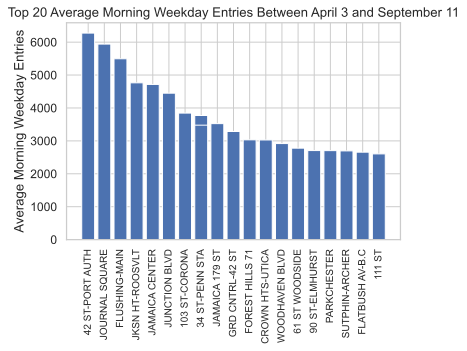

In [7]:
# FIRST ROUND. AM ENTRIES
#group by station and sum for the few cases
# where there are multiple readings in the time range for that date/station
station_am_entry = df_am.groupby(["STATION","LINENAME", "DATE"])[['entries_diffs']].sum().reset_index()

# am entries. Across all days for that station, so take mean
station_am_all_entry = station_am_entry.groupby(["STATION",'LINENAME'])[['entries_diffs']].mean().reset_index() \
    .sort_values('entries_diffs',ascending=False)


# first graph
plt.bar(x=station_am_all_entry['STATION'][:20], height=station_am_all_entry['entries_diffs'][:20])
plt.xticks(rotation=90, fontsize = 10);
plt.ylabel("Average Morning Weekday Entries");
plt.title('Top 20 Average Morning Weekday Entries Between April 3 and September 11')
plt.savefig('allAM_6mo.png',dpi = 600,bbox_inches = 'tight')

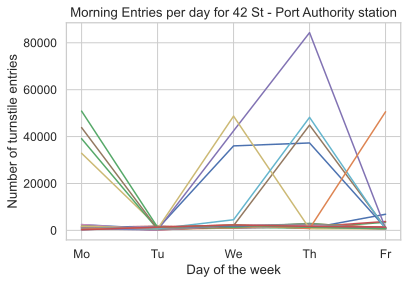

In [8]:
#check an outlier in the bar chart
station_daily = station_am_entry[station_am_entry['STATION'] == 'JOURNAL SQUARE'].copy()

station_daily['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily['DATE']).dt.dayofweek
station_daily['WEEK_OF_YEAR'] = pd.to_datetime(station_daily['DATE']).dt.isocalendar().week
for i, group in station_daily.groupby('WEEK_OF_YEAR'):
    plt.plot(group['DAY_OF_WEEK_NUM'], group['entries_diffs'])
station_daily.head() 
station_daily.shape
plt.xlabel('Day of the week')
plt.ylabel('Number of turnstile entries')
plt.xticks(np.arange(5),['Mo','Tu','We','Th','Fr'])
plt.title('Morning Entries per day for 42 St - Port Authority station');
plt.savefig('PortAuth_6Mo.png',dpi = 600,bbox_inches = 'tight');
#note there are only 5 days out of 6 full months that have high numbers. 
#Mean is probably an outlier. Use graph to demonstrate why don't use Journal Square
# can reuse this code and change station name to check for other outliers;


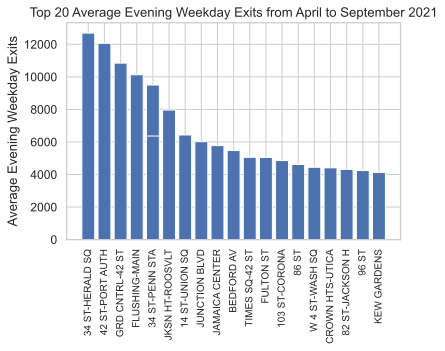

In [9]:
# SECOND ROUND. EVENING EXITS
#group by station and sum for the few cases
# where there are multiple readings in the time range
station_pm_exit = df_pm.groupby(["STATION",'LINENAME', "DATE"])[['exits_diffs']].sum().reset_index()
#across all days per station so take mean
station_pm_all_exit = station_pm_exit.groupby(["STATION",'LINENAME'])[['exits_diffs']].mean().reset_index() \
    .sort_values('exits_diffs',ascending=False)

#graph 2
plt.bar(x=station_pm_all_exit['STATION'][:20], height=station_pm_all_exit['exits_diffs'][:20])
plt.xticks(rotation=90, fontsize = 10);
plt.ylabel("Average Evening Weekday Exits");
plt.title('Top 20 Average Evening Weekday Exits from April to September 2021')
plt.savefig('allPMexits_6Mo.png',dpi = 600,bbox_inches = 'tight')

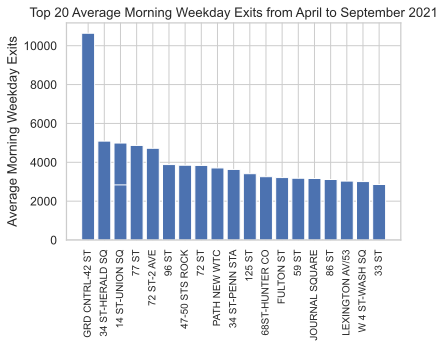

In [10]:
# THIRD ROUND. MORNING EXITS
#sum for few cases where multiple readings - see above
station_am_exits = df_am.groupby(["STATION","LINENAME", "DATE"])[['exits_diffs']].sum().reset_index()
# take mean because averaging across days
station_am_all_exit = station_am_exits.groupby(["STATION",'LINENAME'])[['exits_diffs']].mean().reset_index() \
    .sort_values('exits_diffs',ascending=False)

## make sure all the dataframes and the labels are correct!!
plt.bar(x=station_am_all_exit['STATION'][:20], height=station_am_all_exit['exits_diffs'][:20])
plt.xticks(rotation=90, fontsize = 10);
plt.ylabel("Average Morning Weekday Exits");
plt.title('Top 20 Average Morning Weekday Exits from April to September 2021')
plt.savefig('allAMexits_6MO.png',dpi = 600,bbox_inches = 'tight');

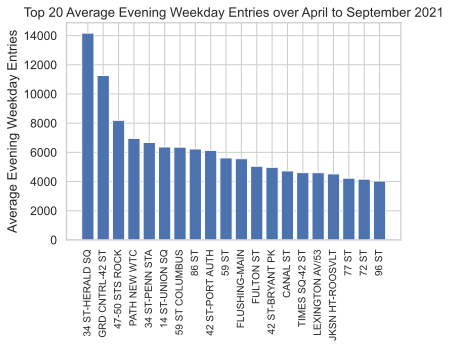

In [11]:
# FOURTH ROUND. EVENING ENTRIES
# weird name to confirm using correct dataframe
#sum in case of multiple entries on a day/station/linename combo
station_pm_eentries = df_pm.groupby(["STATION","LINENAME", "DATE"])[['entries_diffs']].sum().reset_index()
#mean across all days
station_pm_all_eentry = station_pm_eentries.groupby(["STATION",'LINENAME'])[['entries_diffs']].mean().reset_index() \
    .sort_values('entries_diffs',ascending=False)
station_pm_all_eentry.head()
# make sure dataframes and labels are correct!!
plt.bar(x=station_pm_all_eentry['STATION'][:20], height=station_pm_all_eentry['entries_diffs'][:20])
plt.xticks(rotation=90, fontsize = 10);
plt.ylabel("Average Evening Weekday Entries");
plt.title('Top 20 Average Evening Weekday Entries over April to September 2021')
plt.savefig('allPMentries_6MO.png',dpi = 600,bbox_inches = 'tight');

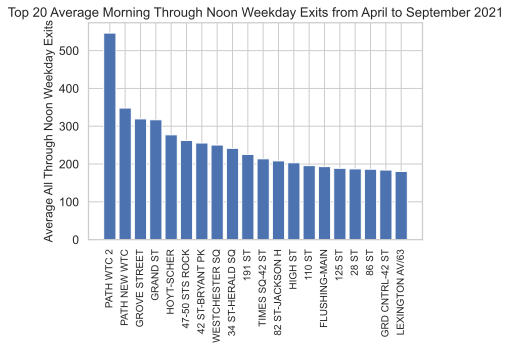

In [12]:
# test the noon exits to see if capture more riders than 8-9:30
mask = ((df4.just_time >= datetime.time(11, 30)) & (df4.just_time <= datetime.time(12)))
df_noon = df4[mask].copy()

station_noon_exit = df_noon.groupby(['key',"STATION", "DATE"])[['exits_diffs']].sum().reset_index()

station_noon_all_exits = station_noon_exit.groupby(["STATION"])[['exits_diffs']].mean().reset_index() \
    .sort_values('exits_diffs',ascending=False)
plt.bar(x=station_noon_all_exits['STATION'][:20], height=station_noon_all_exits['exits_diffs'][:20])
plt.xticks(rotation=90, fontsize = 10);
plt.ylabel("Average All Through Noon Weekday Exits", fontsize = 12);
plt.title('Top 20 Average Morning Through Noon Weekday Exits from April to September 2021')
plt.savefig('allnoon_exits.png',dpi = 600,bbox_inches = 'tight')

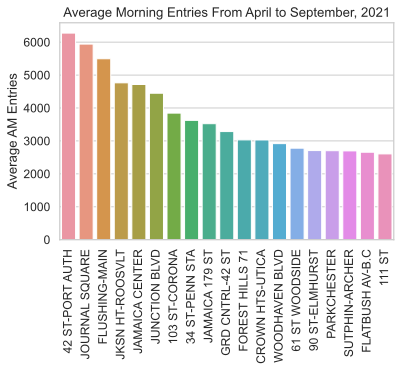

In [14]:
# The morning entries higher numbers than noon. Make a pretty graph of them
mm = sns.barplot(x=station_am_all_entry['STATION'][:20], y=station_am_all_entry['entries_diffs'][:20],ci = None)
mm.set_xticklabels(mm.get_xticklabels(), 
                          rotation=90);
mm.set(xlabel = '',ylabel='Average AM Entries');
mm.set(title = 'Average Morning Entries From April to September, 2021');
plt.savefig('rainbowAMentries.png',dpi = 600,bbox_inches = 'tight');

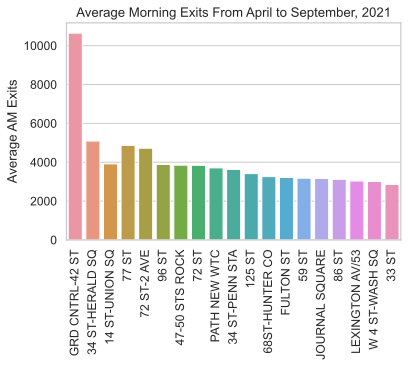

In [17]:
# Make a pretty graph of the morning exits as well
nn = sns.barplot(x=station_am_all_exit['STATION'][:20], y=station_am_all_exit['exits_diffs'][:20], ci = None)
nn.set_xticklabels(nn.get_xticklabels(), 
                          rotation=90);
nn.set(xlabel = '',ylabel='Average AM Exits');
nn.set(title = 'Average Morning Exits From April to September, 2021');
plt.savefig('rainbowAMexits.png',dpi = 600,bbox_inches = 'tight');



In [18]:
# collect the top 20 entries and exits in the four groups 
aa= station_am_all_entry[['STATION','entries_diffs']][:20] # AM ENTRY
bb= station_am_all_exit[['STATION','exits_diffs']][:20]    # AM EXIT
cc=station_pm_all_eentry[['STATION','entries_diffs']][:20] # PM ENTRY
dd = station_pm_all_exit[['STATION','exits_diffs']][:20]   # PM EXIT

# rename the columns so can combine all four arrays into one
aa.rename(columns = {'entries_diffs':'diffs'}, inplace = True)
bb.rename(columns = {'exits_diffs':'diffs'}, inplace = True) 
cc.rename(columns = {'entries_diffs':'diffs'}, inplace = True)
dd.rename(columns = {'exits_diffs':'diffs'}, inplace = True)
ee=np.concatenate((aa,bb,cc,dd))
# same as DataFrame so easy to sort
ff = pd.DataFrame(ee)
ff.sort_values(1,ascending= False,inplace = True)
# drop duplicates
gg=ff.drop_duplicates(0)
# export table to Excel
gg.to_excel(r'highestStations.xlsx', index = False)